# 1. Dataloader

In [1]:
from training.dataset.dataloader import SimpleHDF5Dataset

In [2]:
# === Step 2: Example usage
#val_dataset = SimpleHDF5Dataset("/data/cristian/paper_2025/Testing/ISLR/WLASL/WLASL100/WLASL100_135-Test.hdf5",
#"/data/cristian/paper_2025/Testing/ISLR/WLASL/WLASL100/wlasl_100_maplabels.json",augmentation=True,noise_std=0.001,device="cuda")
val_dataset = SimpleHDF5Dataset("/data/cristian/paper_2025/Testing/ISLR/WLASL/WLASL100/WLASL100_135-Test.hdf5",
"/data/cristian/paper_2025/Testing/ISLR/WLASL/WLASL100/wlasl_100_maplabels.json",use_filtering=True)
print("Loaded validation set")
print("Total samples:", len(val_dataset))
data, name, label, video_name = val_dataset[0]
print("Data shape:", data.shape)  # [T, V, 2]
print("Name:", name)
print("Label:", label)
print("Video name:", video_name)


Loaded validation set
Total samples: 258
Data shape: torch.Size([35, 135, 2])
Name: accident
Label: 51
Video name: rgb/WLASL100/test/00625.mp4


In [3]:
data.shape #torch.Size([35, 135, 2])

torch.Size([35, 135, 2])

# 2. Visualization

In [4]:
import sys
import cv2
import copy 
sys.path.insert(1, '../../src/')
import matplotlib.pyplot as plt
from wholebodypose.models.rtmpose.model import RTMPoseModel
from wholebodypose.utils.vision import DrawerPose
import numpy as np

In [5]:
draw_skeleton = DrawerPose(mode_coco=True)

## 2.1 Visualization of one frame

In [6]:
data += 0.5  # Normalize to [0, 1] for visualization

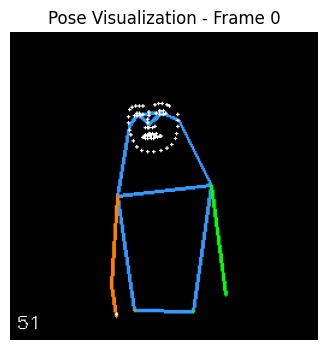

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# === Configuration
img_size = 256
frame_idx = 0  # You can change this to visualize other frames
frame = data[frame_idx].numpy()  # shape: (V, 2), normalized coordinates

# === Scale keypoints to image size
num_keypoints = 133
keypoints = (frame[:num_keypoints] * img_size).astype(np.float32)  # shape: (133, 2)
keypoints = keypoints[np.newaxis, ...]  # shape: (1, 133, 2) for batch-like compatibility

# === Create dummy scores: 1 for visible keypoints, 0 for missing ones
dummy_scores = np.ones((1, num_keypoints, 1), dtype=np.float32)
# Zero out keypoints with average position near origin
dummy_scores[(keypoints[:, :, 0] + keypoints[:, :, 1]) / 2.0 < 0.01] = 0

# === Create base black image
img_rgb = np.zeros((img_size, img_size, 3), dtype=np.uint8)

# === Draw skeleton (replace with your own function)
img_vis = img_rgb.copy()
img_vis = draw_skeleton(
    img_vis,
    keypoints,
    dummy_scores,
    kpt_thr=0.5,
    line_width=2,
    radius=1
)
img_vis = cv2.putText(img_vis, f"{label}", (5, img_size - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

# === Display the image
fig = plt.figure(figsize=(4, 4))
plt.imshow(img_vis)
plt.title(f"Pose Visualization - Frame {frame_idx}")
plt.axis("off")
plt.show()


## 2.2 Visualization of video

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import display, Image
import tempfile
import os
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def visualize_pose_as_gif(
    data,
    label="unknown",
    img_size=256,
    fps=10,
    keypoints_to_use=133,
    kpt_thr=0.01,
    line_width=2,
    radius=1,
    draw_fn=None,
    gif_path=None
):
    """
    Render a pose sequence as a GIF and display it in a Jupyter notebook.

    Args:
        data (torch.Tensor or np.ndarray): (T, V, 2) keypoints, normalized.
        label (str): video label (displayed on frame).
        img_size (int): output image size.
        fps (int): frames per second.
        keypoints_to_use (int): number of keypoints to draw.
        kpt_thr (float): minimum value to keep a keypoint.
        radius (int): circle radius for keypoints.
        draw_fn (function): custom skeleton drawing function (optional).
        gif_path (str): custom path (optional).
    """
    if hasattr(data, "numpy"):
        data = data.numpy()

    data = data[:, :keypoints_to_use, :]+0.5  # [T, V, 2]
    T, V, _ = data.shape
    images = []

    for t in range(T):
        frame = (data[t] * img_size).astype(np.int32)  # [V, 2]
        scores = np.ones((V, 1), dtype=np.float32)
        scores[(frame[:, 0] + frame[:, 1]) / 2.0 < kpt_thr * img_size] = 0

        canvas = np.zeros((img_size, img_size, 3), dtype=np.uint8)
        if draw_fn is not None:
            canvas = draw_fn(canvas.copy(), frame[np.newaxis], scores[np.newaxis], kpt_thr,
                             line_width=line_width,radius=radius)
        else:
            for (x, y), s in zip(frame, scores):
                if s > 0 and 0 <= x < img_size and 0 <= y < img_size:
                    cv2.circle(canvas, (x, y), radius, (0, 0, 255), -1)

        # Add label text
        cv2.putText(canvas, f"{label}", (5, img_size - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        images.append(canvas)

    # Save as GIF
    if gif_path is None:
        gif_path = tempfile.NamedTemporaryFile(suffix=".gif", delete=False).name
    imageio.mimsave(gif_path, images, fps=fps)

    return gif_path
def display_gif_inline(gif_path):
    return HTML(f'<img src="{gif_path}" width="256" height="256">')

In [9]:
data,name, label, _ = val_dataset[0]
gif_path = visualize_pose_as_gif(data, label=name, draw_fn=draw_skeleton,gif_path="../../results/gifs/sample_accident.gif")
print("gif_path:",gif_path)
display_gif_inline(gif_path)

gif_path: ../../results/gifs/sample_accident.gif


In [10]:
!du -h ../../results/gifs/sample_accident.gif

44K	../../results/gifs/sample_accident.gif
